# Ride-Hailing Revenue Optimization via Integer Linear Programming

## Project Overview
This project models the problem of a ride-hailing driver choosing rides to maximize revenue using Integer Linear Programming (ILP). The goal is to determine the optimal sequence of rides a driver should accept within their working time constraints to maximize total revenue.

## Problem Description
- Each ride is characterized by:
  - Start and end locations
  - Duration
  - Expected revenue 
  - Availability time window
- The driver starts at a fixed location and has a limited working time
- "Deadhead" moves (traveling without passengers) incur costs
- All parameters are deterministic (no uncertainty)



In [1]:
# import libraries
import gurobipy as gp


In [51]:

# locations
locations = [1, 2, 3, 4, 5]
# Driver constraints
max_working_time = 100


# Ride data
rides = {
    (1, 2): {'price': 10, 'time': 1},  
    (1, 3): {'price': 8, 'time': 1},
    (2, 4): {'price': 6, 'time': 2},
    (3, 4): {'price': 4, 'time': 1},
    (4, 5): {'price': 5, 'time': 1},
    (1, 5): {'price': 10, 'time': 3},
    (2, 3): {'price': 12, 'time': 2},
    (3, 5): {'price': 2, 'time': 1},
    (2, 1): {'price': 12, 'time': 2},
    (3, 1): {'price': 12, 'time': 2},
    (4, 1): {'price': 12, 'time': 2},
    (5, 1): {'price': 12, 'time': 2},
    
}

# Cost of location to location (both directions)
cost = {
    (1, 2): 2,
    (1, 3): 8,
    (1, 4): 6,
    (1, 5): 4,
    (2, 1): 2,
    (2, 3): 5,
    (2, 4): 10,
    (2, 5): 8,
    (3, 1): 8,
    (3, 2): 5,
    (3, 4): 4,
    (3, 5): 1,
    (4, 1): 6,
    (4, 2): 10,
    (4, 3): 4,
    (4, 5): 5,
    (5, 1): 4,
    (5, 2): 8,
    (5, 3): 1,
    (5, 4): 5,
    
}

In [52]:
model = gp.Model("Ride-Hailing Revenue Optimization")

# Decision variables
x = model.addVars(rides.keys(), vtype=gp.GRB.BINARY, name="x")
y = model.addVars(cost.keys(), vtype=gp.GRB.BINARY, name="y")

#y = model.addVars(locations, vtype=gp.GRB.INTEGER, lb=1, ub=len(locations), name="y")

# Objective function
model.setObjective(
    gp.quicksum(rides[i, j]['price'] * x[i, j] for i, j in rides) - 
    gp.quicksum(cost[i, j] * y[i, j] for i, j in cost),
    gp.GRB.MAXIMIZE)


# Constraints
# 1. Startig location constraint
model.addConstr(gp.quicksum(x[i, j] for (i, j) in rides if i == 1) == 1)

# 2. Flow constraint 
for k in locations:
    if k != 1:
        inflow = gp.quicksum(x[i, k] for (i, k2) in rides if k2 == k) + gp.quicksum(y[i, k] for (i, k2) in cost if k2 == k)
        outflow = gp.quicksum(x[k, j] for (k1, j) in rides if k1 == k) + gp.quicksum(y[k, j] for (k1, j) in cost if k1 == k)
        model.addConstr(inflow == outflow)

# 3. Time window constraints
model.addConstr(gp.quicksum(x[1, j] for (i, j) in rides if i == 1) + 
               gp.quicksum(y[1, j] for (i, j) in cost if i == 1) == 1)


model.update()
model.optimize()


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D60)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6 rows, 32 columns and 59 nonzeros
Model fingerprint: 0x33dcf6bf
Variable types: 0 continuous, 32 integer (32 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 22.0000000
Presolve removed 1 rows and 6 columns
Presolve time: 0.02s
Presolved: 5 rows, 26 columns, 44 nonzeros
Variable types: 0 continuous, 26 integer (24 binary)

Root relaxation: objective 4.400000e+01, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      44.0000000   44.00000  0.00%     -    0s

E

In [53]:
model.write('model.lp')

In [54]:
revenue = 0
for v in model.getVars():
    if v.x > 0.5:
        print(f'{v.varName}: {v.x}')
        # Extract variable type (x or y) and locations
        var_type = v.varName[0]
        start, end = v.varName[2:-1].split(',')
        start, end = int(start), int(end)
        
        if var_type == 'x':
            # This is a passenger ride
            revenue += rides[(start, end)]['price'] - cost[(start, end)]
        elif var_type == 'y':
            # This is a deadhead move (empty trip)
            revenue -= cost[(start, end)]
            
print(f'Total revenue: {revenue}')


x[1,2]: 1.0
x[3,4]: 1.0
x[4,5]: 1.0
x[2,3]: 1.0
x[3,5]: 1.0
x[5,1]: 1.0
y[5,3]: 1.0
Total revenue: 23


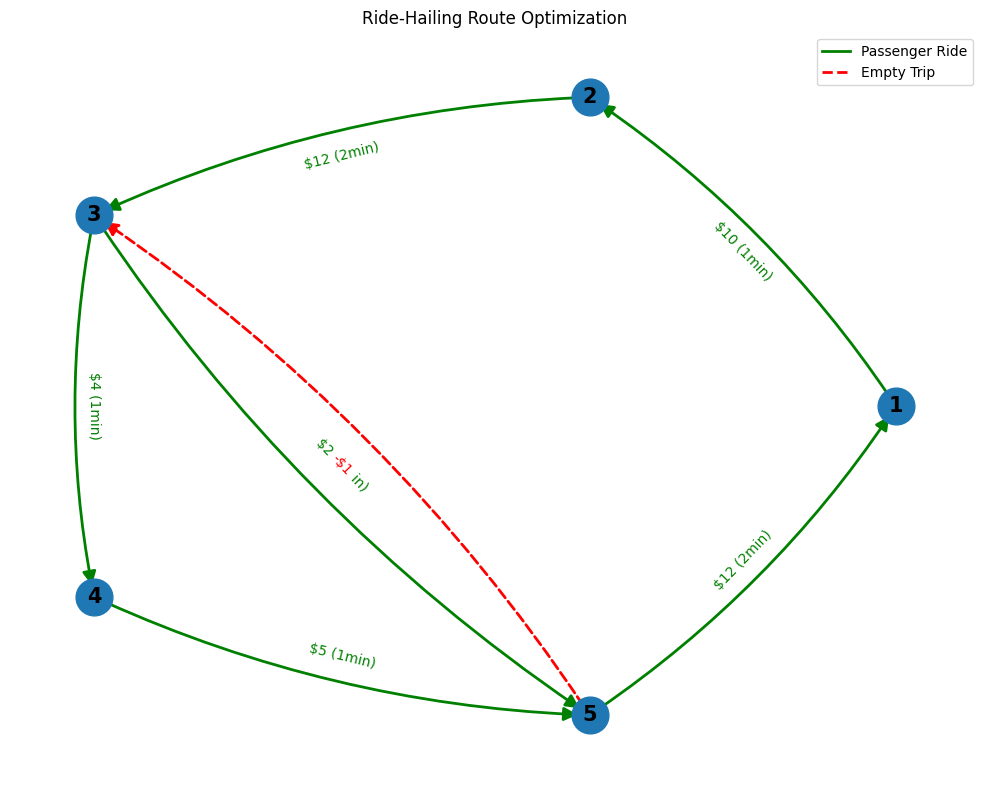

In [55]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add all locations as nodes
for loc in locations:
    G.add_node(loc)

# Add edges for chosen rides (x variables) and deadhead moves (y variables)
ride_edges = []
deadhead_edges = []

for v in model.getVars():
    if v.x > 0.5:
        var_type = v.varName[0]
        start, end = v.varName[2:-1].split(',')
        start, end = int(start), int(end)
        
        if var_type == 'x':
            ride_edges.append((start, end))
        elif var_type == 'y':
            deadhead_edges.append((start, end))

# Position nodes in a circle layout
pos = nx.circular_layout(G)

# Draw the graph
plt.figure(figsize=(10, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# Draw ride edges in green with solid lines
nx.draw_networkx_edges(G, pos, edgelist=ride_edges, edge_color='green', 
                      width=2, arrowsize=20, connectionstyle='arc3,rad=0.1')

# Draw deadhead edges in red with dashed lines
nx.draw_networkx_edges(G, pos, edgelist=deadhead_edges, edge_color='red',
                      width=2, style='dashed', arrowsize=20, 
                      connectionstyle='arc3,rad=0.1')

# Add node labels
nx.draw_networkx_labels(G, pos, font_size=15, font_weight='bold')

# Add edge labels with prices and times for rides
ride_labels = {(i, j): f"${rides[i,j]['price']} ({rides[i,j]['time']}min)" 
               for i, j in ride_edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=ride_labels, font_color='green')

# Add edge labels with costs for deadhead moves
deadhead_labels = {(i, j): f"-${cost[i,j]}" for i, j in deadhead_edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=deadhead_labels, font_color='red')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='Passenger Ride'),
    Line2D([0], [0], color='red', linestyle='--', lw=2, label='Empty Trip')
]
plt.legend(handles=legend_elements)

plt.title("Ride-Hailing Route Optimization")
plt.axis('off')
plt.tight_layout()
plt.show()

In this version I try to add time slot availabilty for each ride
Also, for making the question more logical, the driver has this option to wait in one location to get the next ride or move to another location

In [64]:
model.write('model2.lp')